In [1]:
%matplotlib widget
import numpy as np
import cuml
from cuml import KMeans
from cuml.cluster import KMeans
import cudf
import sys
import pandas as pd
import matplotlib.pyplot as plt

# Load original and predicted

In [36]:
processedData = np.load('/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/origAndPredictedSVD001_block7.npz')
data = processedData['arr_0']
nChannel, nSample = data.shape

print(data.shape)

(19, 1100367)


# Prepare stacked residuals

In [37]:
nStack = 3

residualStack = np.zeros((nSample, nStack * nChannel))
counter = 0
for i in range(0, nSample, nStack):
    if i + nStack >= nSample:
        break
    thisPredictor = np.repeat(data[:,i].transpose(), nStack)
    thisToPredict = data[:,i + 1: i + 1 + nStack].flatten(order='F').transpose()
    thisResidual = thisToPredict - thisPredictor
    residualStack[counter, :] = thisResidual
    counter += 1
    
residualStack = residualStack[0:counter,:]
print(residualStack.shape)

(366788, 57)


# Fit kmeans model

In [38]:
%%time
kmeansInputData = residualStack
n_clusters = 2**16
n_init = 3

kmeans = KMeans(n_clusters=n_clusters, verbose=6, n_init=n_init)
kmeans.fit(kmeansInputData)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(kmeans.n_iter_)
print(centroids.shape)
print(kmeans.inertia_)nChannel

1
(65536, 57)
655041.8539087015
CPU times: user 1h 24min 47s, sys: 1min 20s, total: 1h 26min 8s
Wall time: 1h 26min 9s


# Save KMeans model

In [4]:
path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/centroids_001_block7.npy'
np.save(path, centroids)

path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/labels_001_block7.npy'
np.save(path, kmeans.labels_)

# Load KMeans model

In [ ]:
path = '/content/drive/MyDrive/NeuroResearch/Data/eegCompress/processedData/centroids_001_block7.npy'
centroids = np.load(path)
nCentroids,_ = centroids.shape
kmeansCuml = KMeans(n_clusters=nCentroids, init=centroids, n_init=1)

# Reconstruct the data

In [17]:
%%time
numSampleInput = 1
numSampleOutput = 1
nChannel,failureIndex = data.shape

predicted = np.zeros_like(data)
predicted[:,0:numSampleInput] = data[:,0:numSampleInput]

for i in range(numSampleInput, int(nSample/numSampleOutput)):
    if i % 100000 == 0:
        print(i)
        
    thisOutput = predicted[:,i-1: i-1 + numSampleOutput]
    thisResidual = data[:,i:i + numSampleOutput] - thisOutput
    thisResidualReshape = np.reshape(thisResidual,(nChannel * numSampleInput,),order='F')
    index = int(kmeans.predict(np.expand_dims(thisResidualReshape, 0))[0])
    predicted[:,i:i + numSampleOutput] = thisOutput + np.reshape(centroids[index,:], (nChannel,numSampleOutput))
    
    if np.any(np.isnan(predicted[:,i])):
        failureIndex = i
        print("nan: " + str(failureIndex))
        break
    

ValueError: Expected 38 columns but got 19 columns.

In [20]:
np.mean(np.abs(data - predicted)), np.max(np.abs(data - predicted))

(0.088087894, 17.651955)

 current best: (0.044626124, 0.6939485)

# Two Sample Residual

In [18]:
%%time
numSampleInput = 1

predicted = np.zeros_like(data)
predicted[:,0:numSampleInput] = data[:,0:numSampleInput]

for i in range(0, nSample - 3, 2):
    if i % 100000 == 0:
        print(i)
        
    thisOriginal = np.concatenate((data[:,i], data[:,i]), axis = 0)
    thisToPredict = np.concatenate((data[:,i + 1], data[:,i + 2]), axis = 0)
    thisResidual = -thisOriginal + thisToPredict
    #thisResidualReshape = np.reshape(thisResidual,(nChannel * numSampleInput,),order='F')
    index = int(kmeans.predict(np.expand_dims(thisResidual, 0))[0])
    thisCentroid = centroids[index,:]
    predicted[:,i + 1] = data[:,i] + thisCentroid[0:nChannel].transpose()
    predicted[:,i + 2] = data[:,i] + thisCentroid[nChannel:].transpose()
    
    if np.any(np.isnan(predicted[:,i])):
        failureIndex = i
        print("nan: " + str(failureIndex))
        break
    

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
CPU times: user 13min 26s, sys: 238 ms, total: 13min 27s
Wall time: 13min 30s


In [40]:
labels = kmeans.labels_

# Reconstruct the data from stacked residuals and centroids

In [42]:
%%time

predicted = np.zeros_like(data)
predicted[:,1] = data[:,1]

stackedRows, stackedCols = residualStack.shape
counter = 1
for i in range(0, stackedRows):
    if i % 100000 == 0:
        print(i)
        
    #thisPredictor = np.repeat(data[:,i].transpose(), nStack)
    index = labels[i]
    thisCentroid = centroids[index,:]
    for j in range(nStack):
        predicted[:, counter] = data[:, counter - 1 - j] + thisCentroid[j * nChannel: (j+1) * nChannel].transpose()
        counter += 1
        

0
100000
200000
300000
CPU times: user 3.11 s, sys: 121 ms, total: 3.24 s
Wall time: 3.13 s


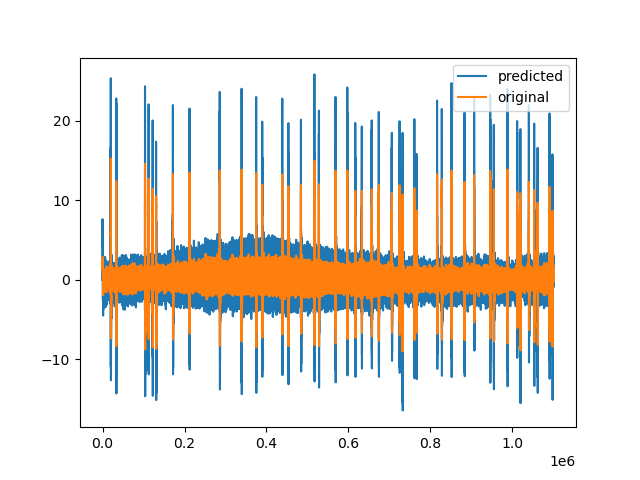

In [43]:
channel = 0

plt.figure()
plt.plot(predicted[channel,:], label='predicted')
plt.plot(data[channel,:], label='original')
#plt.plot(residual[channel,:])
plt.legend()
plt.show()

# Save original and predicted

In [10]:
path = '/blue/gkalamangalam/jmark.ettinger/eegCompress/processedData/origAndPredictedLossy.npz'
dataToSaveList = [data[:,0:failureIndex], predicted[:, 0:failureIndex]]
np.savez_compressed(path, *dataToSaveList)

# Scratch

In [ ]:
# PREPARE UNIT NORM RESIDUALS

residualNormalized = np.zeros((nSample-1, nChannel))
norms = np.linalg.norm(residual, axis=1)
for i in range(nSample-1):
    for j in range(nChannel):
        residualNormalized[i,j] = residual[i,j]/norms[i] 
print(residualNormalized.shape)

In [ ]:
# RECONSTRUCT USING NORM
%%time
numSampleInput = 1
numSampleOutput = 1
failureIndex,_ = kmeansInputData

predicted = np.zeros_like(kmeansInputData)
predicted[:,0:numSampleInput] = data[:,0:numSampleInput]

dotProduct = np.zeros(nSample - 1)

for i in range(numSampleInput, nSample):
    if i % 100000 == 0:
        print(i)
        
    thisOutput = predicted[:,i-1]
    thisResidual = data[:,i] - thisOutput
    thisResidualUnit = thisResidual/np.linalg.norm(thisResidual) 
    index = int(kmeans.predict(np.expand_dims(thisResidualUnit, 0))[0])
    thisCentroid = centroids[index,:]
    
    thisDotProduct = np.dot(thisResidual, thisCentroid)
    dotProduct[i-1] = thisDotProduct
    predicted[:,i] = thisOutput + (thisDotProduct * thisCentroid)
    
    if np.any(np.isnan(predicted[:,i])):
        failureIndex = i
        print("nan: " + str(failureIndex))
    